In [1]:
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

# Load some fake data
txtdat = np.loadtxt("data.txt")
fpix = txtdat[:,:49]
truth = txtdat[:,49]
fpld = txtdat[:,50]

In [2]:
# Iterate!
def Init(fpix, K = 5):
    '''
    
    '''
    
    # Compute the 1st order PLD model
    fsap = np.sum(fpix, axis = 1)
    A = fpix / fsap.reshape(-1,1)
    w = np.linalg.solve(np.dot(A.T, A), np.dot(A.T, fsap))
    model = np.dot(A, w)
    fdet = fsap - model + 1
    
    # The data matrix
    F = np.array(fpix)
    
    # Estimate S from PLD de-trended flux
    S = 0.5 + np.array(fdet) / 2
    S = np.ones_like(fdet)
    
    # Estimate A with PCA
    X = F / S.reshape(-1, 1)
    X -= np.nanmedian(X, axis = 0)
    U, _, _ = np.linalg.svd(X)
    A = U[:,:K]
    A = np.hstack((np.ones((fpix.shape[0], 1)), A))
    
    return F, S, A

def Step(F, S, A):
    '''
    
    '''
    
    # Dimensions
    nt = F.shape[0]
    
    # Update B
    ATA = np.dot(A.T, (S ** 2)[:,None] * A)
    ATF = np.dot(A.T, S[:,None] * F)
    B = np.linalg.solve(ATA, ATF)

    # Update A
    b1 = B[0,:]
    BBT = np.dot(B[1:], B[1:].T)
    BFT = np.dot(B[1:], (F / S[:,None] - b1[None,:]).T)
    A = np.hstack((np.ones(nt).reshape(-1,1), np.linalg.solve(BBT, BFT).T))
    
    # Update S
    M = np.dot(A, B)
    S = np.sum(M * F, axis = 1) / np.sum(M * M, axis = 1)
    
    return F, S, A

In [3]:
F, S, A = Init(fpix, K = 9)
for n in range(1000):
    F, S, A = Step(F, S, A)

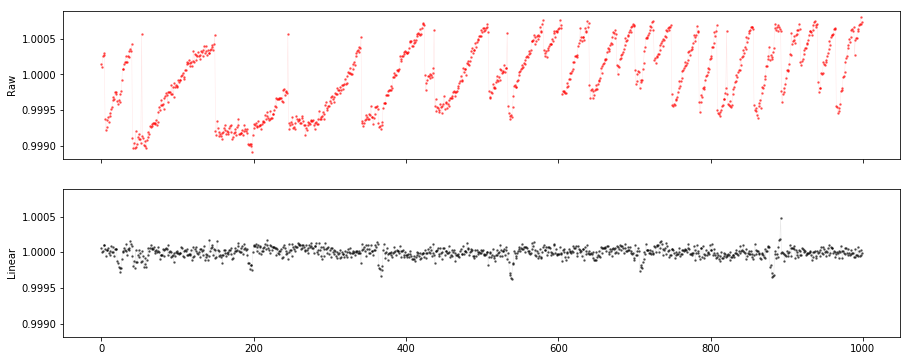

In [4]:
fsap = np.sum(fpix, axis=1)
fig, ax = pl.subplots(2, figsize = (15, 6), sharex = True, sharey = True)
ax[0].plot(fsap, 'r.', ms = 3, alpha = 0.5);
ax[0].plot(fsap, 'r-', lw = 0.5, alpha = 0.1);
ax[0].set_ylabel("Raw");
ax[1].plot(S, 'k.', ms = 3, alpha = 0.5);
ax[1].plot(S, 'k-', lw = 0.5, alpha = 0.1);
ax[1].set_ylabel("Linear");